<a href="https://colab.research.google.com/github/11carol/class_area/blob/develop/fus%C3%A3o_recorte_reproje%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install rasterio
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 232 kB 5.2 MB/s 


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from rasterio.warp import reproject
import PyPDF2

In [57]:
def load_landsat_image(img_folder, bands, width=None):
    # initialize the dictionaries
    image = {}
    ds = {}
    
    path = Path(img_folder)
    
    # adjust the out_shape
    if width is not None:
        out_shape = (int(width/7601 * 7761), width)
        print(f'Using output shape ({out_shape})')
    else:
        out_shape = None
    
    # loop through the given bands to load
    for band in bands:
        # considering the landsat images end with *_SR_B#.TIF, we will use it to locate the correct file
        file = next(path.glob(f'*_T1_{band}.TIF'))
        print(f'Opening file {file}')
        ds.update({band: rasterio.open(file)})
        image.update({band: ds[band].read(1, out_shape=out_shape)})

    return image, ds

In [58]:
def create_rgb(img, b_r, b_g, b_b, alpha=1.):
    rgb = np.stack([img[b_r], img[b_g], img[b_b]], axis=-1)
    rgb = rgb/rgb.max() * alpha
    
    # clip values outside the boundaries
    rgb[rgb>1] = 1
    rgb[rgb<0] = 0
    
    return rgb

In [59]:
# load the image
img, image_ds = load_landsat_image('/content/image', ['B2', 'B3', 'B4', 'B5', 'QA_PIXEL'], width=1000)

Using output shape ((1021, 1000))
Opening file /content/image/LC08_L1TP_228061_20220808_20220818_02_T1_B2.TIF
Opening file /content/image/LC08_L1TP_228061_20220808_20220818_02_T1_B3.TIF
Opening file /content/image/LC08_L1TP_228061_20220808_20220818_02_T1_B4.TIF
Opening file /content/image/LC08_L1TP_228061_20220808_20220818_02_T1_B5.TIF
Opening file /content/image/LC08_L1TP_228061_20220808_20220818_02_T1_QA_PIXEL.TIF


In [61]:
# create the RGB for the image
rgb = create_rgb(img, 'B4', 'B3', 'B2', alpha=2.)

plt.imsave('/content/image/rgb.pdf', rgb)

In [62]:
L8_flags = {
    'dilated_cloud': 1<<1,
    'cirrus': 1<<2, 
    'cloud': 1<<3,
    'shadow': 1<<4, 
    'snow': 1<<5, 
    'clear': 1<<6,
    'water': 1<<7
}

In [63]:
def get_mask(mask, flags_list):
    
    # first we will create the result mask filled with zeros and the same shape as the mask
    final_mask = np.zeros_like(mask)
    
    # then we will loop through the flags and add the 
    for flag in flags_list:
        # get the mask for this flag
        flag_mask = np.bitwise_and(mask, L8_flags[flag])
        
        # add it to the final flag
        final_mask = final_mask | flag_mask
    
    return final_mask > 0

In [64]:
def plot_masked_rgb(red, green, blue, mask, color_mask=(1, 0, 0), transparency=0.5, brightness=2):
    
    # to improve our visualization, we will increase the brightness of our values
    red = red / red.max() * brightness
    green = green / green.max() * brightness
    blue = blue / blue.max() * brightness
    
    red = np.where(mask==True, red*transparency+color_mask[0]*(1-transparency), red)
    green = np.where(mask==True, green*transparency+color_mask[1]*(1-transparency), green)
    blue = np.where(mask==True, blue*transparency+color_mask[2]*(1-transparency), blue)
    
    rgb = np.stack([red, green, blue], axis=2)
    
    # clip values outside the boundaries
    rgb[rgb>1] = 1
    rgb[rgb<0] = 0
    
    return rgb

In [65]:
def normalized_difference(img, b1, b2, eps=0.0001):
    band1 = np.where((img[b1]==0) & (img[b2]==0), np.nan, img[b1])
    band2 = np.where((img[b1]==0) & (img[b2]==0), np.nan, img[b2])
    
    return (band1 - band2) / (band1 + band2)

In [66]:
clouds = get_mask(img['QA_PIXEL'], ['cirrus', 'cloud', 'dilated_cloud'])
shadows = get_mask(img['QA_PIXEL'], ['shadow'])
ndwi = normalized_difference(img, 'B3', 'B5')
water = ndwi > 0.0

In [67]:
masked_rgb = plot_masked_rgb(img['B4'], img['B3'], img['B2'], water, color_mask=(0, 0, 1), transparency=0.4, brightness=2.)
masked_rgb = plot_masked_rgb(masked_rgb[..., 0], masked_rgb[..., 1], masked_rgb[..., 2], shadows, color_mask=(1, 0, 0), transparency=0.7, brightness=1.)
masked_rgb = plot_masked_rgb(masked_rgb[..., 0], masked_rgb[..., 1], masked_rgb[..., 2], clouds, color_mask=(1, 1, 0), transparency=0.7, brightness=1.)

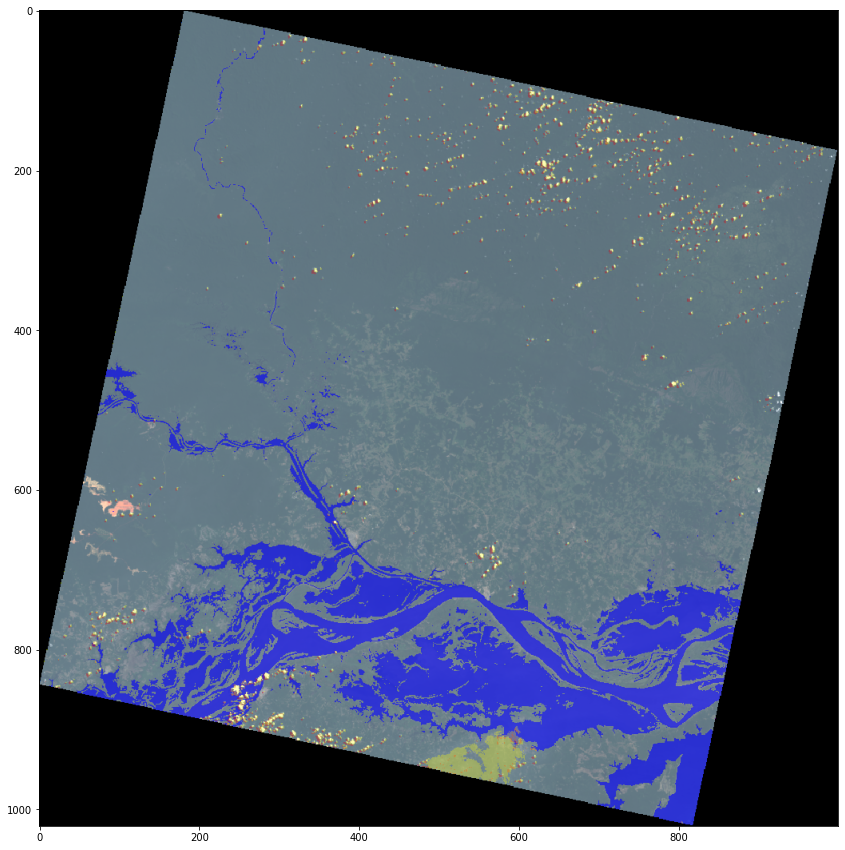

In [68]:
plt.imsave('/content/image/masked_rgb.pdf', masked_rgb)

plt.figure(figsize=(15, 15))
plt.imshow(masked_rgb)

Original shape: (1021, 1000)
Fixing first dimension as size 2: (2, 510500)
Reshaping it to a vector: (1021000,)


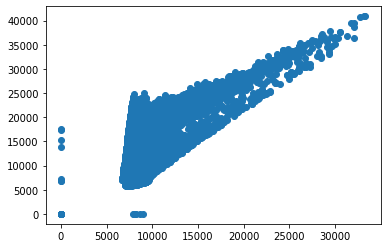

In [69]:

print(f"Original shape: {img['B3'].shape}")
print(f"Fixing first dimension as size 2: {img['B3'].reshape(2, -1).shape}")
print(f"Reshaping it to a vector: {img['B3'].reshape(-1).shape}")

plt.scatter(img['B3'].reshape(-1), img['B5'].reshape(-1))

In [70]:
# load the data mask (255 indicate valid pixel)
data_mask = image_ds['B3'].read_masks(1, out_shape=img['B3'].shape)==255

# get just the valid pixels and scale them down
b3 = img['B3'][data_mask] * 0.0001
b5 = img['B5'][data_mask] * 0.0001


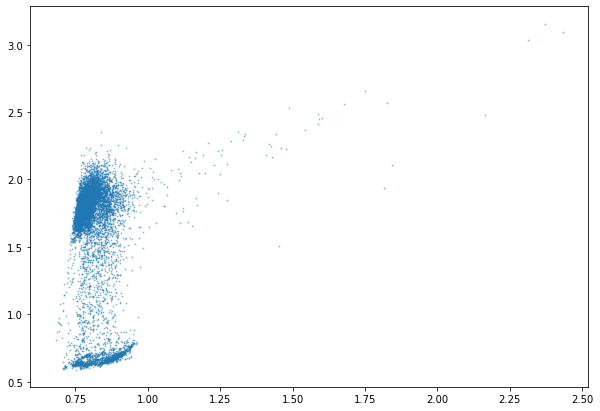

In [71]:
# resample
size=10000
max_idx = b3.shape[0]

random_idxs = np.random.randint(0, max_idx, size)
sampled_b3 = b3[random_idxs]
sampled_b5 = b5[random_idxs]

plt.figure(figsize=(10, 7))
plt.scatter(sampled_b3, sampled_b5, s=0.5, alpha=0.5)

In [72]:
land = ~(clouds | shadows | water)
groups = ['clouds', 'land', 'shadows', 'water']
masks = [clouds, land, shadows, water]
colors = ['orange', 'green', 'brown', 'blue']

Text(0, 0.5, 'Band 5 (NIR)')

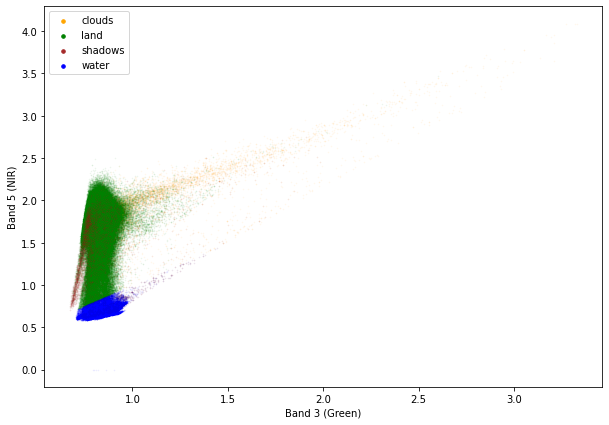

In [73]:
plt.figure(figsize=(10, 7))
for group, mask, color in zip(groups, masks, colors):
    mask = mask[data_mask]
    
    masked_b3 = b3[mask]
    masked_b5 = b5[mask]
    

    plt.scatter(masked_b3, masked_b5, s=0.5, alpha=0.05, c=color, label=group)

# make the legend marker opaque
leg = plt.legend(markerscale=5.)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
plt.xlabel('Band 3 (Green)')
plt.ylabel('Band 5 (NIR)')

In [74]:
def save_scatter(filename, x_arr, y_arr, data_mask, masks, names, colors, x_label, y_label, 
                 pixels=1000, size=0.5, alpha=0.5, xlim=None, ylim=None):
    
    # slice just valid points
    x = x_arr[data_mask]
    y = y_arr[data_mask]
    
    # set figure size
    plt.figure(figsize=(10, 7))
    
    # resample
    max_idx = x.shape[0]
    random_idxs = np.random.randint(0, max_idx, pixels)
    sampled_x = x[random_idxs]
    sampled_y = y[random_idxs]
    
    # go through groups, masks and colors to create the plots
    for group, mask, color in zip(groups, masks, colors):
        mask = mask[data_mask][random_idxs]

        masked_x = sampled_x[mask]
        masked_y = sampled_y[mask]

        plt.scatter(masked_x, masked_y, s=size, alpha=alpha, c=color, label=group) 

    # make the legend marker opaque
    leg = plt.legend(markerscale=5.)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.xlabel(x_label)
    plt.ylabel(y_label)    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.savefig(filename)

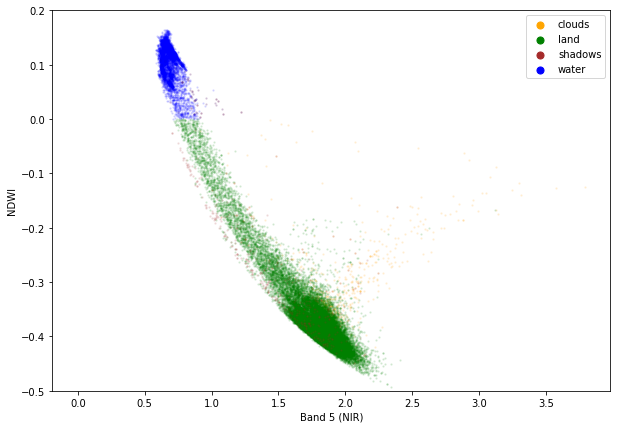

In [85]:
save_scatter(filename='/content/image/scatter1.pdf',
             x_arr=img['B5']*0.0001,
             y_arr=ndwi,
             data_mask=data_mask,
             masks=masks,
             names=groups,
             colors=colors,
             x_label='Band 5 (NIR)',
             y_label='NDWI',
             pixels=50000,
             size=2,
             alpha=0.1,
             ylim=(-0.5, 0.2)
            )
def merge_pdfs(out_file, pdfs):
    report = PdfFileMerger()
    for pdf in pdfs:
        report.append(pdf)
    report.write(out_file)


    pdfs = ['/content/rgb.pdf', '/content/masked_rgb.pdf', '/content/scatter1.pdf']

    merge_pdfs('/content/image_report.pdf', pdfs)